# CHSH 不等式


*Estimated QPU usage: 4 minutes (tested on IBM Kyiv)*

## 背景

このチュートリアルでは、量子コンピューター上で実験を実行し、Estimator primitive による CHSH 不等式の破れを実証します。

CHSH 不等式は、著者の Clauser、Horne、Shimony、Holt にちなんで名付けられ、ベルの定理 (1969) を実験的に証明するために使用されます。この定理は、局所性を仮定した隠れた変数理論では量子力学におけるエンタングルメントの結果の一部を説明できないと主張しています。CHSH 不等式の違反は、量子力学が局所隠れ変数理論と互換性がないことを示すために使用されます。これは、量子力学の基礎を理解するための重要な実験です。

2022年のノーベル物理学賞は、量子情報科学における先駆的な研究、特にベルの不等式の破れを実証したもつれた光子の実験により、Alain Aspect、John Clauser、Anton Zeilingerの3人に授与されました。

## 要件
このチュートリアルを開始する前に、以下がインストールされていることを確認してください。

* Qiskit SDK 1.0 or later
* Qiskit Runtime (`pip install qiskit-ibm-runtime`) 0.22 or later
* Visualization support (`'qiskit[visualization]'`)


## Step 1. 古典的な入力を量子問題にマッピングする


この実験では、エンタングルメントペアを作成し、各量子ビットを 2 つの異なる基底で測定します。最初の量子ビットの基底に $A$ と $a$、2 番目の量子ビットの基底に $B$ と $b$ というラベルを付けます。これにより、CHSH 量 $S_1$ を計算できます。

$$
S_1 = A(B-b) + a(B+b).
$$

各観測値は $+1$ または $-1$ のいずれかです。明らかに、項 $B\pm b$ の 1 つは $0$ でなければならず、もう 1 つは $\pm 2$ でなければなりません。したがって、$S_1 = \pm 2$ です。$S_1$ の平均値は次の不等式を満たしている必要があります。

$$
|\langle S_1 \rangle|\leq 2.
$$


$S_1$ を $A$、$a$、$B$、$b$ で展開すると次のようになります。

$$
|\langle S_1 \rangle| = |\langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle| \leq 2
$$

別のCHSH量$S_2$を定義することができます。

$$
S_2 = A(B+b) - a(B-b),
$$

これにより、別の不等式が生じます：

$$
|\langle S_2 \rangle| = |\langle AB \rangle + \langle Ab \rangle - \langle aB \rangle + \langle ab \rangle| \leq 2
$$

量子力学が局所性を仮定した隠れた変数理論によって記述できる場合、前述の不等式は必ず成り立ちます。しかし、このノートブックで実証されているように、これらの不等式は量子コンピューターでは破られる可能性があります。したがって、量子力学は局所隠れ変数理論と互換性がありません。


さらに詳しい理論を学びたい場合は、John Watrous による[Entanglement in Action](https://learning.quantum-computing.ibm.com/course/basics-of-quantum-information/entanglement-in-action#the-chsh-game) をご覧ください。

<iframe loading="lazy" width="800" height="450" style="margin-top: 40px; margin-bottom: 40px;" src="https://www.youtube.com/embed/GSsElSQgMbU?si=ZhRKJKHMLRq0g3E1&amp;start=2426" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>


ベル状態 $|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$ を作成することにより、量子コンピューターの 2 つの量子ビット間のエンタングル ペアを作成します。Estimator primitive を使用すると、2 つの CHSH 量 $\langle S_1\rangle$ と $\langle S_2\rangle$ の期待値を計算するために必要な期待値 ($\langle AB \rangle、\langle Ab \rangle、\langle aB \rangle$、および $\langle ab \rangle$) を直接取得できます。Estimator primitive を導入する前は、測定結果から期待値を構築する必要がありました。

2 番目の量子ビットを $Z$ 基底と $X$ 基底で測定します。1 番目の量子ビットも直交基底で測定されますが、2 番目の量子ビットに対する角度で測定されます。角度は $0$ から $2\pi$ の間でスイープします。ご覧のとおり、Estimator primitive を使用すると、パラメーター化された回路の実行が非常に簡単になります。一連の CHSH 回路を作成するのではなく、測定角度を指定するパラメーターとそのパラメーターの一連の位相値を持つ 1 つの CHSH 回路を作成するだけで済みます。

最後に、結果を分析し、測定角度に対してプロットします。特定の測定角度範囲では、CHSH 量の期待値が $|\langle S_1\rangle| > 2$ または $|\langle S_2\rangle| > 2$ であることがわかります。これは、CHSH 不等式が破れていることを示しています。


### 設定


In [1]:
# General
import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

In [2]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
backend.name

'ibm_kyoto'

### パラメータ化されたCHSH回路を作成する



まず、パラメータ $\theta$（これを `theta` と呼ぶ）を使用して回路を記述します。[`Estimator` primitive](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) は、オブザーバブルの期待値を直接提供することで、回路の構築と出力分析を大幅に簡素化できます。特にノイズの多いシステムでの短期的なアプリケーションなど、多くの重要な問題は、期待値の観点から定式化できます`Estimator` (V2) primitiveは、提供されたオブザーバブルに基づいて測定基準を自動的に変更できます。


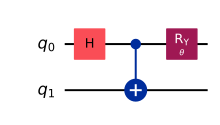

In [3]:
theta = Parameter("$\\theta$")

chsh_circuit = QuantumCircuit(2)
chsh_circuit.h(0)
chsh_circuit.cx(0, 1)
chsh_circuit.ry(theta, 0)
chsh_circuit.draw(output="mpl", idle_wires=False, style="iqp")

### 後に割り当てる位相の値のリストを作成する

パラメーター化された CHSH 回路を作成したら、次のステップで回路に割り当てる位相の値のリストを作成します。次のコードを使用して、等間隔で $0$ から $2 \pi$ の範囲の 21 個の位相値のリスト (つまり、$0$、$0.1 \pi$、$0.2 \pi$、...、$1.9 \pi$、$2 \pi$) を作成できます。


In [4]:
number_of_phases = 21
phases = np.linspace(0, 2 * np.pi, number_of_phases)
# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

### オブザーバブル

ここで、期待値を計算するためのオブザーバブルが必要です。今回の場合、各量子ビットの直交基底を調べ、最初の量子ビットのパラメータ化された $Y-$ 回転が、2 番目の量子ビット基底に関して測定基底をほぼ連続的にスイープできるようにします。したがって、オブザーバブル $ZZ$、$ZX$、$XZ$、および $XX$ を選択します。


In [5]:
# <CHSH1> = <AB> - <Ab> + <aB> + <ab> -> <ZZ> - <ZX> + <XZ> + <XX>
observable1 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)])

# <CHSH2> = <AB> + <Ab> - <aB> + <ab> -> <ZZ> + <ZX> - <XZ> + <XX>
observable2 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", 1), ("XZ", -1), ("XX", 1)])

## Step 2. 量子実行のために問題を最適化する


ジョブの合計実行時間を短縮するために、V2 primitives は、ターゲット システムでサポートされている命令と接続に準拠する回路とオブザーバブル (命令セットアーキテクチャ (ISA) 回路とISAオブザーバブルと呼ばれる) のみを受け入れます。

### ISA 回路


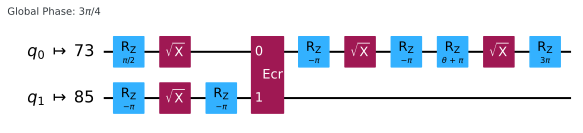

In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

chsh_isa_circuit = pm.run(chsh_circuit)
chsh_isa_circuit.draw(output="mpl", idle_wires=False, style="iqp")

### ISA オブザーバブル


同様に、[`Runtime Estimator V2`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2#run) でジョブを実行する前に、オブザーバブルを変換してバックエンドと互換性を持たせる必要があります。変換は、`SparsePauliOp` オブジェクトの  `apply_layout` メソッドを使用して実行できます。



In [7]:
isa_observable1 = observable1.apply_layout(layout=chsh_isa_circuit.layout)
isa_observable2 = observable2.apply_layout(layout=chsh_isa_circuit.layout)

## Step 3. Qiskit primitive を使用して実行する

[`Estimator`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) への 1 回の呼び出しで実験全体を実行します。

[Qiskit Runtime `Estimator`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) primitive を作成して、期待値を計算できます。 `EstimatorV2.run()` メソッドは、 `primitive unified blocs (PUBs)` の反復可能オブジェクトを受け取ります。各 PUB は、`(circuit, observables, parameter_values: Optional, precision: Optional)` という形式の反復可能オブジェクトです。

In [8]:
# To run on a local simulator:
# Use the StatevectorEstimator from qiskit.primitives instead.

estimator = Estimator(mode=backend)

pub = (
    chsh_isa_circuit,  # ISA circuit
    [[isa_observable1], [isa_observable2]],  # ISA Observables
    individual_phases,  # Parameter values
)

job_result = estimator.run(pubs=[pub]).result()

## Step 4. 後処理を行い、結果を古典形式で返す

Estimator は、オブザーバブルの両方の期待値、$\langle ZZ \rangle - \langle ZX \rangle + \langle XZ \rangle + \langle XX \rangle$ と $\langle ZZ \rangle + \langle ZX \rangle - \langle XZ \rangle + \langle XX \rangle$ を返します。


In [9]:
chsh1_est = job_result[0].data.evs[0]
chsh2_est = job_result[0].data.evs[1]

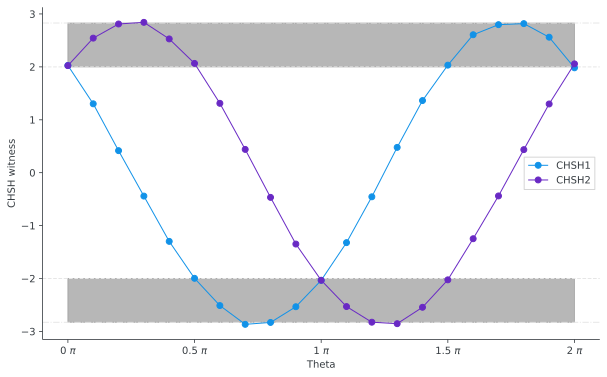

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, chsh2_est, "o-", label="CHSH2", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()

図では、線と灰色の領域が境界を区切っています。最も外側の (一点鎖線) 線は量子境界 ($\pm 2$) を区切っており、内側の (破線) 線は古典境界 ($\pm 2\sqrt{2}$) を区切っています。CHSH 証拠量が古典境界を超える領域があることがわかります。おめでとうございます! 実際の量子システムで CHSH 不等式の違反を実証できました。

In [11]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.25.0'

In [12]:
import qiskit

qiskit.version.get_version_info()

'1.1.1'

## Tutorial Survey

<table style="width: 100%;">
<tbody>
<tr>
<td style="width: 10%;"><img src="https://learning-api.quantum.ibm.com/assets/53171443-b07b-4ae6-a4be-9aec32a854f5" alt="Survey" width="100%" height="100%"></td>
<td style="width: 80%;"><strong><a title="Tutorial Survey" href="https://your.feedback.ibm.com/jfe/form/SV_3xxAgm1SF1wGp9k" target="_blank">Tutorial Survey</a></strong><br>Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.</td>
</tr>
</tbody>
</table>
